# Stock Price Moves
---
[GitHub](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/10_bayesian_machine_learning/01_updating_conjugate_priors.ipynb)

### Import Libaries 

In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from fredapi import Fred
from matplotlib.ticker import FuncFormatter

api_key = os.environ.get("FRED_API_KEY")
fred = Fred(api_key=api_key)

In [2]:
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
np.random.seed(42)
sns.set_style('dark')

### Formatting Helper

In [4]:
def format_plot(axes, i, p, y, trials, success, true_p, tmle, tmap=None): 
    fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
    if i >= 9: 
        axes[i].set_xlabel("$p$, Success Probability")
        axes[i].xaxis.set_major_formatter(fmt)
    else: 
        axes[i].axes.get_xaxis().set_visible(False)

    if i%3 == 0: 
        axes[i].set_ylabel("Posterior Probability")

    axes[i].set_yticks([])
    axes[i].plot(p,y, lw=1, c='k')
    axes[i].fill_between(p,y,color='darkblue',alpha=0.4)
    axes[i].vlines(true_p,0,max(10,np.max(y)), color='k', linestyle='--', lw=1)
    axes[i].set_title(f'Trials: {trials:,d} - Success: {success:,d}')

    if i > 0: 
        smle = r"$\theta_{{\mathrm{{MLE}}}}$ = {:,.2%}".format(tmle)
        axes[i].text(x=0.02, y=0.85, s=smle, transform=axes[i].transAxes)
        smap = r"$\theta_{{\mathrm{{MAP}}}}$ = {:,.2%}".format(tmap)
        axes[i].text(x=0.02, y=0.75, s=smap, transform=axes[i].transAxes)
    
    return axes[i]



# S&P 500 Returns 
---

### Collect Samples of Binarized Daily S&P 500 Returns
 - positive outcome = price increase 
 - `DataFrame.to_hdf`: Hierarchical Data Format (HDF) - self-describing, allowing an application to interpret the structure and contents of a file without no outside information 
    - fast and scalable storage format for numerical data
    - advantage to *read* in relation to CSV
    - slower with *write* because it pickles text data

In [5]:
start_date = '2015'
end_date = '2018'

In [6]:
def sp500_data(start, end): 
    data = fred.get_series('SP500')
    df = pd.DataFrame(data)
    df.to_hdf('data.h5',key='df', mode='w')
    
    df_bin = (df.pct_change().dropna() > 0).astype(int).loc[start:end,0]

    return df_bin

sp500_binary = sp500_data(start_date, end_date)

sp500_binary.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1043 entries, 2015-01-01 to 2018-12-31
Series name: 0
Non-Null Count  Dtype
--------------  -----
1043 non-null   int64
dtypes: int64(1)
memory usage: 16.3 KB


### Create Random Sample of Trading Days 

In [7]:
n_days = [0,1,3,5,10,25,50,100,250,500,750,1000]

# Random Sample of Trading Days 
random_outcomes = sp500_binary.sample(n_days[-1])

In [8]:
# Initial 500 Trading Days 
initial500 = sp500_binary.iloc[:n_days[-1]]

### Start From Uninformative Prior P(Θ)
- allocate equal probability to each possible success in the interval[0,1]

In [9]:
p = np.linspace(0,1,100)

# uniform (uninformative) prior
# aka no prior data 
a = b = 1 

### Computer Posterior for Different Evidence Samples

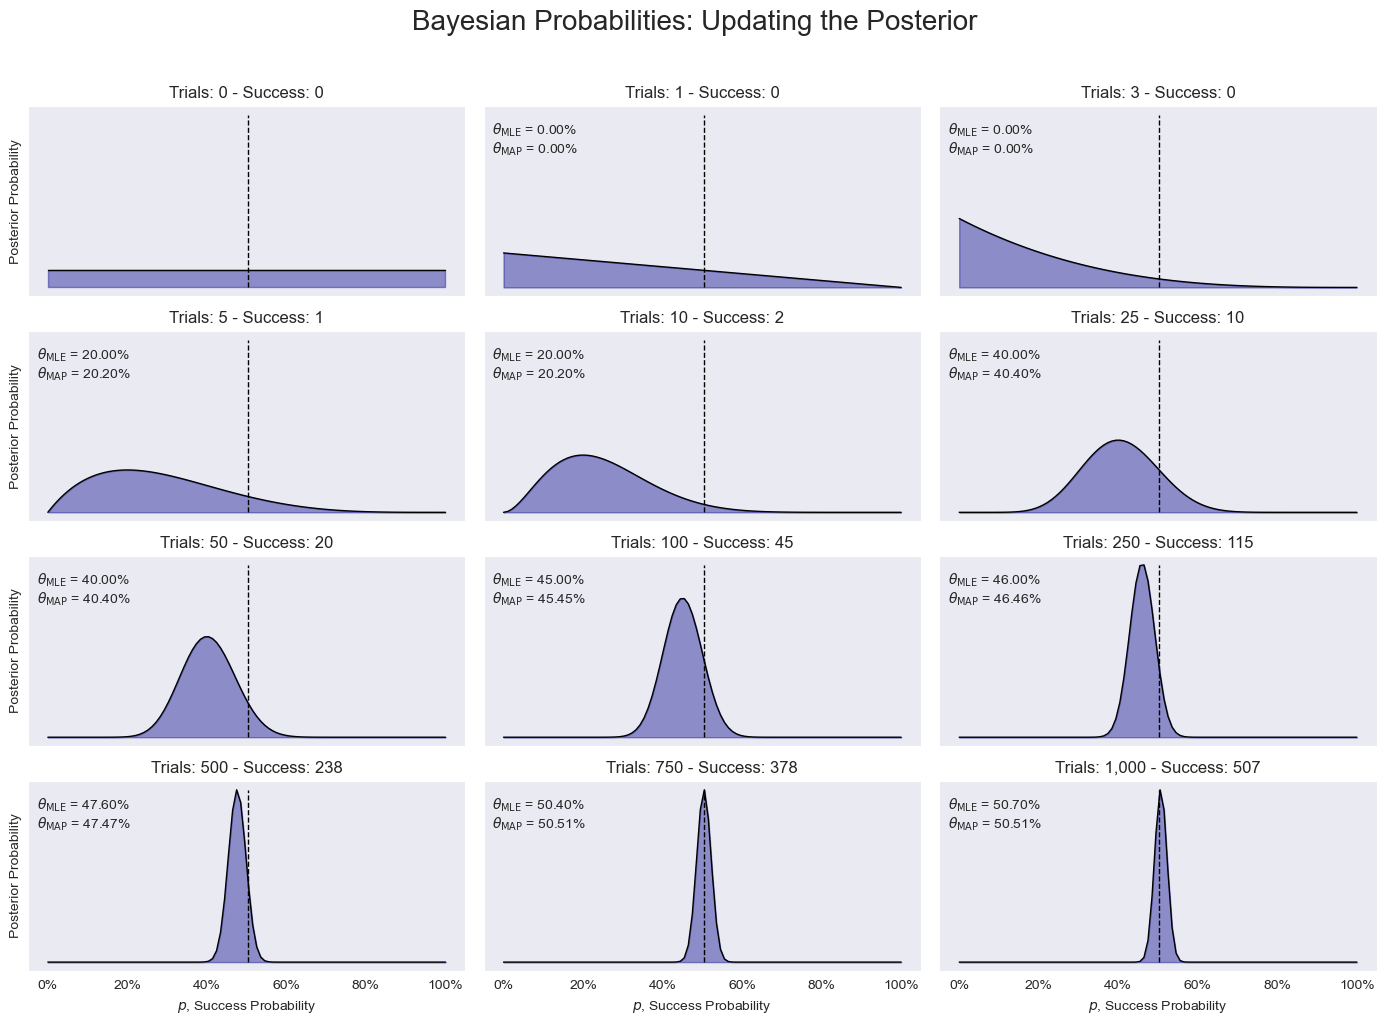

In [10]:
fig, axes  = plt.subplots(nrows=4, ncols=3, figsize=(14,10), sharex=True)
axes = axes.flatten() 
fmt = FuncFormatter(lambda x, _: f'{x:.0%}')


for i, days in enumerate(n_days):
    # New Data 
    successes = initial500.iloc[:days]
    # Maximum Likelihood Estimation (MLE) - picks parameter value Θ that maximizes the likelihood function 
    #theta_mle = np.mean(successes, axis=0)
    theta_mle = successes.mean()
    # Market Up vs. Market Down 
    up = successes.sum()
    down = days - up 
    # Update Conjugate Prior (no prior*likelihood integral calculation -> same distribution)
    update = stats.beta.pdf(p, a+up, b+down)
    # Maximum a Posteriori Probability (MAP) - mode (included prior data even tho here we don't have)
    theta_map = pd.Series(update, index=p).idxmax()

    axes[i] = format_plot(axes, i, p, update, trials=days, success=up,
                     true_p=sp500_binary.mean(), tmle=theta_mle, tmap=theta_map)
    
title = "Bayesian Probabilities: Updating the Posterior"
fig.suptitle(title, y=1.02, fontsize=20)
fig.tight_layout()
plt.show()